**MANASI ADHAV**

**22070126063**

**AIML-A3**

> # Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

import numpy as np
import os

In [2]:
cwd = os.getcwd()
os.chdir(cwd)
print(os.listdir("../input"))

['celeba-dataset']


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

> # Defining Parameters

In [7]:
lr = 2e-4 
batch_size = 128
image_size = 64
channels  = 3
noise_vector = 100
epochs = 10
feat_disc = 64
feat_gen = 64

In [8]:
device

device(type='cuda')

In [9]:
transforms = transforms.Compose([
    transforms.Resize([64,64]),
    transforms.ToTensor(),
    transforms.Normalize([0.5 for i in range(channels)], [0.5 for i in range(channels)])
])

In [10]:
path = '../input/celeba-dataset/img_align_celeba'

In [11]:
dataset = datasets.ImageFolder(path, transform = transforms)

In [12]:
def split_indices(n, val_per, seed = 0):
    n_val = int(n * val_per)
    np.random.seed(seed)
    idx = np.random.permutation(n)
    return idx[n_val : ], idx[: n_val]

In [13]:
val_per = 0.5
rand_seed = 42

train_indices, val_indices = split_indices(len(dataset), val_per, rand_seed)

print(len(train_indices), len(val_indices))

101300 101299


In [14]:
# dataloader
train_sampler = SubsetRandomSampler(train_indices)
dataloader = DataLoader(dataset,batch_size, sampler = train_sampler)

In [15]:
def convblock(in_channels,out_channels,kernel_size=4,stride=2,padding=1):
    layers=[nn.Conv2d(in_channels,out_channels,kernel_size,stride,padding)]
    layers.append(nn.BatchNorm2d(num_features=out_channels))
    layers.append(nn.LeakyReLU(0.2))
    return nn.Sequential(*layers)

def tconvblock(in_channels,out_channels,kernel_size=4,stride=2,padding=1):
    layers=[nn.ConvTranspose2d(in_channels,out_channels,kernel_size,stride,padding)]
    layers.append(nn.BatchNorm2d(num_features=out_channels))
    layers.append(nn.ReLU())
    layers.append(nn.Dropout2d(0.25))
    return nn.Sequential(*layers)

> # Discriminator Model

In [16]:
class Discriminator(nn.Module):
    
    def __init__(self, channels_img, features_d):
        super(Discriminator, self).__init__()
        
        self.disc = nn.Sequential(
            # 3*64*64
            convblock(channels_img, features_d, kernel_size=4, stride=2, padding=1),  # 32*32
            convblock(features_d, features_d*2, kernel_size=4, stride=2, padding=1),  # 16*16
            convblock(features_d*2, features_d*4, kernel_size=4, stride=2, padding=1),  # 8*8
            convblock(features_d*4, features_d*8, kernel_size=4, stride=2, padding=1),  # 4*4
            
            nn.Conv2d(features_d*8, 1, kernel_size=4, stride=2, padding=0),  # 1*1
            nn.Sigmoid()
        )
        
        
    def forward(self, x):
        return self.disc(x)

> # Generator Modeling

In [17]:
class Generator(nn.Module):
    
    def __init__(self, z_dim, channels_img, features_g):
        super(Generator, self).__init__()
        
        self.net = nn.Sequential(
            
            tconvblock(z_dim, features_g*16, kernel_size=4, stride=1, padding=0),  # 4*4
            tconvblock(features_g*16, features_g*8, kernel_size=4, stride=2, padding=1),  # 8*8
            tconvblock(features_g*8, features_g*4, kernel_size=4, stride=2, padding=1),  # 16*16
            tconvblock(features_g*4, features_g*2, kernel_size=4, stride=2, padding=1),  # 32*32
            
            nn.ConvTranspose2d(features_g*2, channels_img, kernel_size=4, stride=2, padding=1),
            nn.Tanh()  # -1,1
        )
        
    
    def forward(self, x):
        return self.net(x)


In [18]:
def initialize_weights(model):
    
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

> # Generator and Discriminator Initiation

In [19]:
gen = Generator(z_dim = noise_vector, channels_img = channels, features_g = feat_gen).to(device)
disc = Discriminator(channels, feat_disc).to(device)
initialize_weights(gen)
initialize_weights(disc)

In [20]:
optg = optim.Adam(gen.parameters(), lr = lr, betas = (0.5, 0.999))
optd = optim.Adam(disc.parameters(), lr = lr, betas = (0.5, 0.999))
loss_fn = nn.BCELoss()

In [21]:
def reset_grad():
    optd.zero_grad()
    optg.zero_grad()

> # Training Discriminator

In [22]:
def train_discriminator(images):
    # create labels, for real image label is 1, for fac=ke 0
    
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)
    
    # loss for real images
    
    outputs = disc(images).reshape(-1)
    d_loss_real = loss_fn(outputs, torch.ones_like(outputs))
    real_score = outputs
    
    z = torch.randn(batch_size,noise_vector, 1, 1).to(device)
    fake_images = gen(z)
    outputs = disc(fake_images).reshape(-1)
    d_loss_fake = loss_fn(outputs, torch.zeros_like(outputs))
    fake_score = outputs
    
    d_loss = (d_loss_real + d_loss_fake)/2
    reset_grad()
    
    d_loss.backward()
    optd.step()
    
    return d_loss, real_score, fake_score

> # Training Generator

In [23]:
def train_generator():
    
    z = torch.randn(batch_size, noise_vector, 1, 1).to(device)
    fake_images = gen(z)
    labels = torch.ones(batch_size, 1).to(device)
    output = disc(fake_images).reshape(-1)
    g_loss = loss_fn(output, torch.ones_like(output))

    # Backprop and optimize
    reset_grad()
    g_loss.backward()
    optg.step()
    return g_loss, fake_images

In [24]:
import os

sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

In [25]:
def show_img(img, label):
    print('Label: ', label)
    plt.imshow(img.permute(1,2,0), cmap = 'gray')

In [26]:
def denorm(x):
  out = (x + 1) / 2
  return out.clamp(0, 1)

In [ ]:
img = dataset[0]
img[0].shape

> # Displaying Image

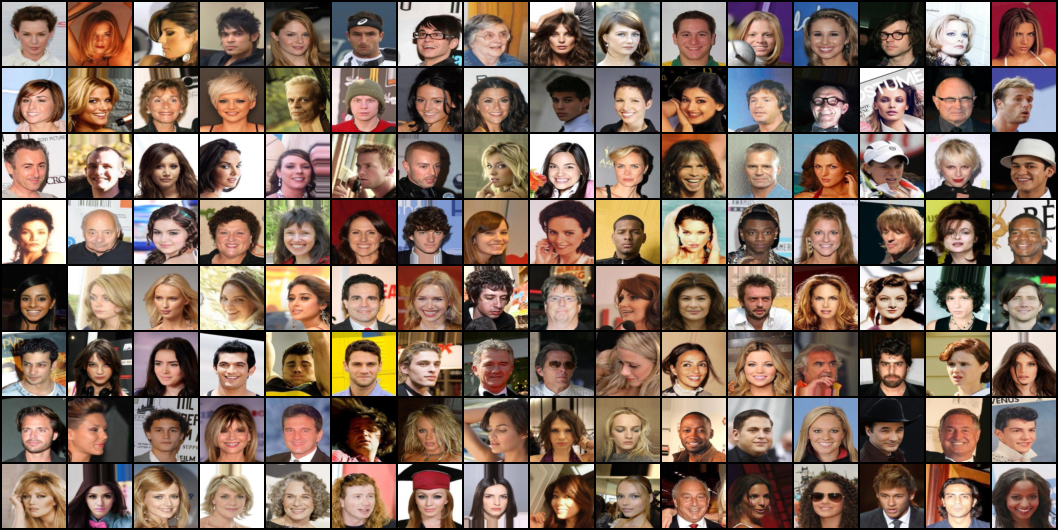

In [27]:
from IPython.display import Image
from torchvision.utils import save_image

# Save some real images
for images, _ in dataloader:
    images = images.reshape(images.size(0), 3, 64, 64)
    save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'), nrow=16)
    break
   
Image(os.path.join(sample_dir, 'real_images.png'))

> # Saving Image

Saving fake_images-0000.png


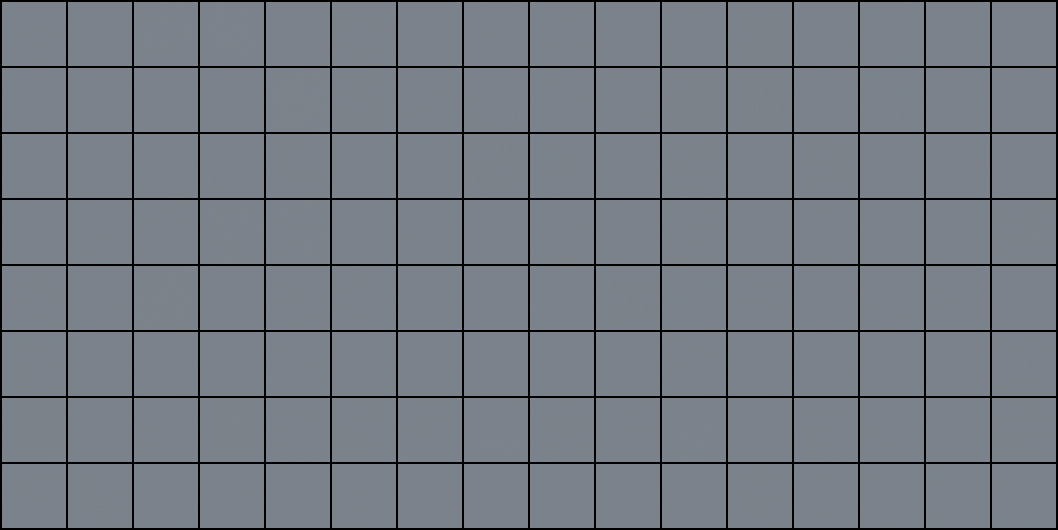

In [28]:
sample_vectors = torch.randn(batch_size, noise_vector, 1, 1).to(device)

def save_fake_images(index):
    fake_images = gen(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 3, 64, 64)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=16)
    
# Before training
save_fake_images(0)
Image(os.path.join(sample_dir, 'fake_images-0000.png'))

> # Training of Model

In [29]:
%%time

total_step = len(dataloader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(epochs):
    for i, (images, _) in enumerate(dataloader):
        # Load a batch & transform to vectors
        images = images.to(device)
        
        # Train the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_images = train_generator()
        
        
        # Inspect the losses
        if (i+1) % 100 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                  .format(epoch+1,epochs, i+1, total_step, d_loss.item(), g_loss.item(), 
                          real_score.mean().item(), fake_score.mean().item()))
        
       
        
    # Sample and save images
    save_fake_images(epoch+1)

Epoch [1/10], Step [100/792], d_loss: 0.1929, g_loss: 2.4252, D(x): 0.77, D(G(z)): 0.09
Epoch [1/10], Step [200/792], d_loss: 0.5949, g_loss: 0.8718, D(x): 0.41, D(G(z)): 0.06
Epoch [1/10], Step [300/792], d_loss: 0.5315, g_loss: 2.6507, D(x): 0.82, D(G(z)): 0.55
Epoch [1/10], Step [400/792], d_loss: 0.4609, g_loss: 2.7412, D(x): 0.81, D(G(z)): 0.48
Epoch [1/10], Step [500/792], d_loss: 0.3625, g_loss: 1.4526, D(x): 0.65, D(G(z)): 0.21
Epoch [1/10], Step [600/792], d_loss: 0.4622, g_loss: 1.6707, D(x): 0.51, D(G(z)): 0.17
Epoch [1/10], Step [700/792], d_loss: 0.5376, g_loss: 1.7847, D(x): 0.59, D(G(z)): 0.36
Saving fake_images-0001.png
Epoch [2/10], Step [100/792], d_loss: 0.3987, g_loss: 1.4083, D(x): 0.61, D(G(z)): 0.21
Epoch [2/10], Step [200/792], d_loss: 0.5422, g_loss: 1.2713, D(x): 0.47, D(G(z)): 0.22
Epoch [2/10], Step [300/792], d_loss: 0.3744, g_loss: 2.0847, D(x): 0.76, D(G(z)): 0.35
Epoch [2/10], Step [400/792], d_loss: 0.3607, g_loss: 1.6184, D(x): 0.63, D(G(z)): 0.19
Epoc

> # Plot Losses & Score

In [30]:
import matplotlib.pyplot as plt

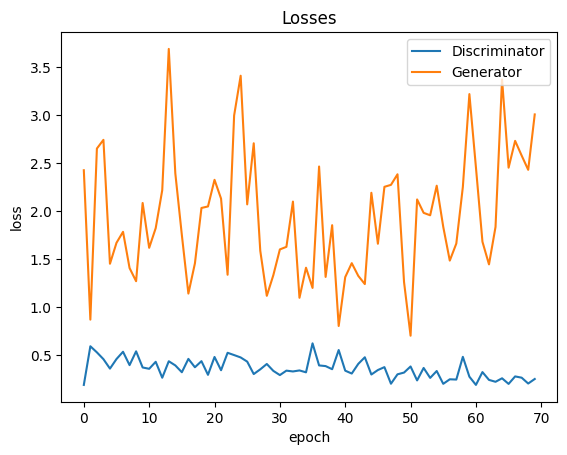

In [31]:
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

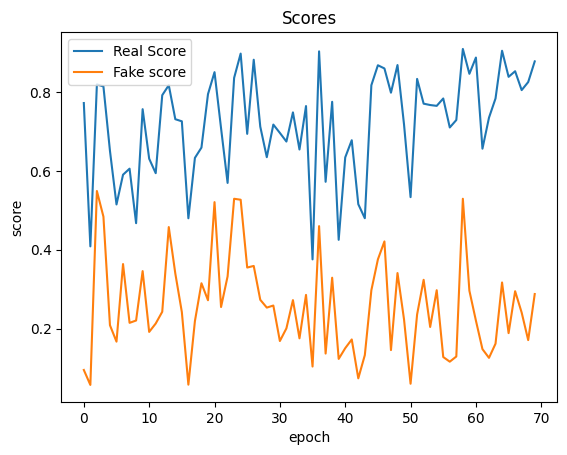

In [32]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score', 'Fake score'])
plt.title('Scores');

> # Check Images

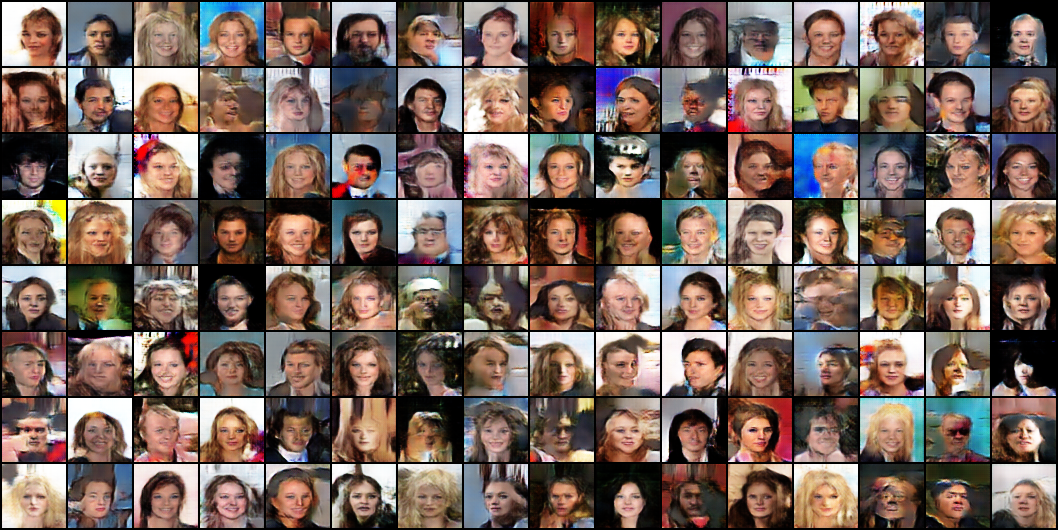

In [33]:
Image('./samples/fake_images-0005.png')

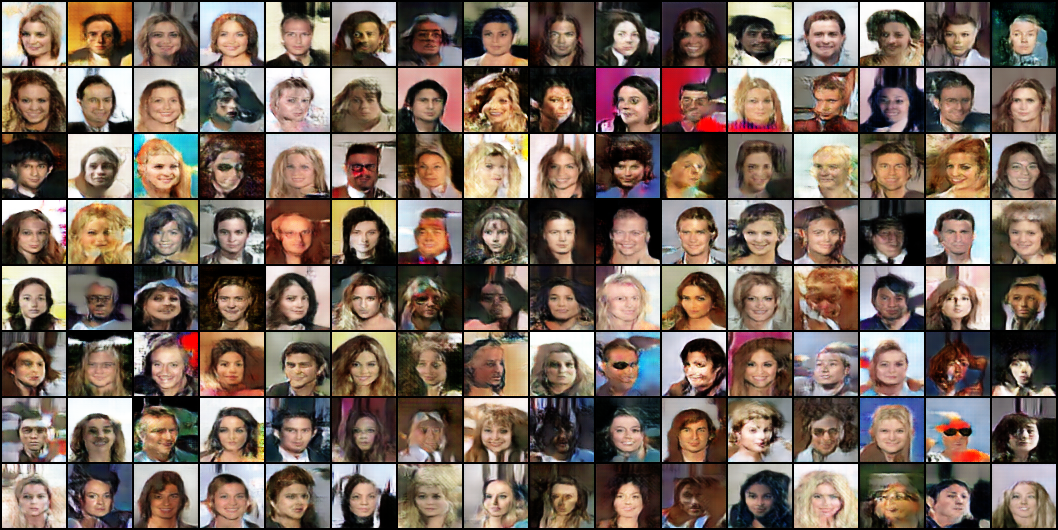

In [34]:
Image('./samples/fake_images-0008.png')

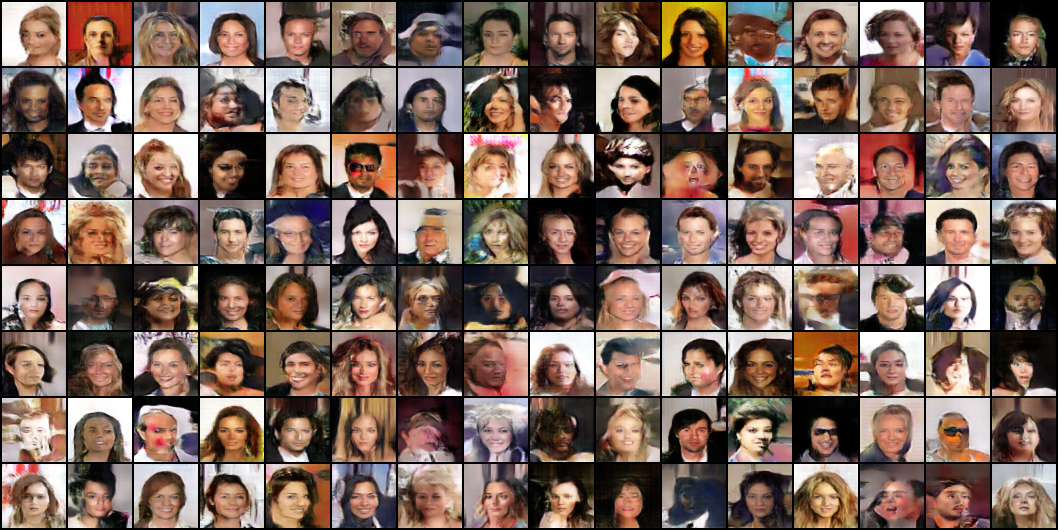

In [35]:
Image('./samples/fake_images-0010.png')